In [4]:
import pandas as pd
from ensemble import StdForestClassifier
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [5]:
df = pd.read_csv('data/train_transaction.csv')

In [6]:
df = df.iloc[:, :-300]
#df = df.sample(frac=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [7]:
X = df.drop(columns=['TransactionID', 'isFraud', 'TransactionDT'])
y = df[['isFraud']]

In [8]:
X,y = undersample.fit_resample(X,y)

In [9]:
X = X.fillna(-1)

In [10]:
X = MEstimateEncoder().fit_transform(X,y)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y,stratify=y,test_size=0.1)

In [17]:
rf = RandomForestClassifier(n_estimators= 10)
rf = StdForestClassifier()

In [18]:
%%time
rf.fit(X_tr,y_tr)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 9.61 s, sys: 98.3 ms, total: 9.71 s
Wall time: 9.77 s


In [20]:
rf.predict(X_tr)

array([[1.  , 0.  ],
       [0.76, 0.24],
       [0.05, 0.95],
       ...,
       [0.98, 0.02],
       [0.91, 0.09],
       [0.99, 0.01]])

In [19]:
print(classification_report(rf.predict(X_te),y_te))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

Feature ranking:
1. feature 8 (0.057987)
2. feature 0 (0.056773)
3. feature 2 (0.044719)
4. feature 26 (0.041564)
5. feature 13 (0.039630)
6. feature 3 (0.038771)
7. feature 21 (0.037136)
8. feature 14 (0.032496)
9. feature 27 (0.028958)
10. feature 30 (0.026781)
11. feature 20 (0.026529)
12. feature 29 (0.026138)
13. feature 24 (0.024737)
14. feature 12 (0.023624)
15. feature 28 (0.023441)
16. feature 42 (0.022308)
17. feature 19 (0.022256)
18. feature 15 (0.020841)
19. feature 6 (0.020121)
20. feature 80 (0.018710)
21. feature 32 (0.017997)
22. feature 37 (0.017299)
23. feature 31 (0.016827)
24. feature 7 (0.016052)
25. feature 10 (0.014655)
26. feature 35 (0.013450)
27. feature 46 (0.013073)
28. feature 89 (0.011295)
29. feature 38 (0.010498)
30. feature 23 (0.010243)
31. feature 82 (0.010227)
32. feature 5 (0.010071)
33. feature 22 (0.009635)
34. feature 36 (0.008833)
35. feature 18 (0.008000)
36. feature 48 (0.007556)
37. feature 47 (0.007300)
38. feature 4 (0.006702)
39. feature 

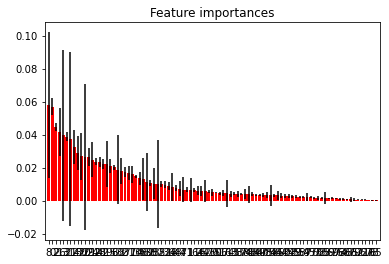

In [15]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()